# NL COVID 19 data exploration

- data from https://data.rivm.nl/covid-19/
- taken 25 July 2020

## Notes

- Given that daily reported numbers are in small quantities
(i.e. <100), changes represented in % changes
can be highly sensitive.
E.g. Changing from 1 to 5 is a 500% change.
- But % change is the only way to
compare change in qty across different slices
of data.
- So take those figures with a pinch of salt.
- That being said, we are looking for anomalies,
so a sufficiently large % change would signal
an abnormally large change.

In [3]:
import pandas as pd
import os
from matplotlib.pyplot import grid,plot,barh,xticks,yticks,legend,show, plot_date
import numpy as np
from pprint import pprint

In [4]:
_DATADIR="../_data"

# There are two datasets
# _DATA_CASES is a CSV file containing data on nationally reported cases
# _DATA_CUMUL contains data on cumulative infections, hospitalizations, deaths
#_DATA_CASES="COVID-19_casus_landelijk.csv"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2020-07-25.csv"

#cases = pd.read_csv(os.path.join(_DATADIR, _DATA_CASES), delimiter=";")
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")

# set dtype of "Date_of_report" to pd.DatetimeTZDtype
# get date in YYYY-MM-DD by accessing
# cumul_ams["Date_of_report"].dt.date
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"])
cumul.info()

cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)
# cumul["Date_of_report"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49545 entries, 0 to 49544
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_report      49545 non-null  datetime64[ns]
 1   Municipality_code   47925 non-null  object        
 2   Municipality_name   47925 non-null  object        
 3   Province            49545 non-null  object        
 4   Total_reported      49545 non-null  int64         
 5   Hospital_admission  49545 non-null  int64         
 6   Deceased            49545 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.6+ MB


In [5]:
# Get only cases from Amsterdam:

cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

# create new column for day of week

cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name())
cumul_ams["Day"].astype("str")

# create new column for week number
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.week)

# compare day on day increments/deltas

def get_daily_delta(df):
    daily_delta_column = []
    rep = df["Total_reported"]
    for i in range(0,len(rep)):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(rep.iloc[i]-rep.iloc[i-1])

    return daily_delta_column

# add daily deltas to df
cumul_ams.insert(
    len(cumul_ams.columns),
    "Daily_delta",
    get_daily_delta(cumul_ams)
)

### Get only the data we want from dataframe

In [6]:
# create working df with:
# date, cumulative day of week, week number, reports

cumuldf = cumul_ams[["Date_of_report","Day","Week","Daily_delta", "Total_reported"]]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 109 to 49287
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date_of_report  135 non-null    datetime64[ns]
 1   Day             135 non-null    object        
 2   Week            135 non-null    int64         
 3   Daily_delta     135 non-null    int64         
 4   Total_reported  135 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 6.3+ KB


### Data from last 10 days

In [7]:
cumuldf.tail(10)

,Date_of_report,Day,Week,Daily_delta,Total_reported
45984,2020-07-16,Thursday,29,20,2774
46351,2020-07-17,Friday,29,16,2790
46718,2020-07-18,Saturday,29,1,2791
47085,2020-07-19,Sunday,29,33,2824
47452,2020-07-20,Monday,30,28,2852
47819,2020-07-21,Tuesday,30,21,2873
48186,2020-07-22,Wednesday,30,18,2891
48553,2020-07-23,Thursday,30,15,2906
48920,2020-07-24,Friday,30,19,2925
49287,2020-07-25,Saturday,30,20,2945


In [8]:
def plot_daily_delta_for_last_n_weeks(df, n=3):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart

    :param df:
    :type df: pandas.DataFrame
    :param n: Last n weeks
    :type n: int
    :return: None
    """
    grid(True)
    xticks(rotation="vertical")
    yticks(np.arange(0, df["Daily_delta"].max(), step=1))

    for week in range(0,n):
        df_week = df["Week"]
        this_week = df[df_week == df_week.max()-week]
        week_start = this_week.iloc[0]["Date_of_report"]
        week_start_d_m = f"{week_start.day}/{week_start.month}"
        week_end = this_week.iloc[-1]["Date_of_report"]
        week_end_d_m = f"{week_end.day}/{week_end.month}"

        plot(this_week["Day"],this_week["Daily_delta"],label=f"{week_start_d_m} – {week_end_d_m}")
    legend()

### Plot day to day change in reported cases, by week

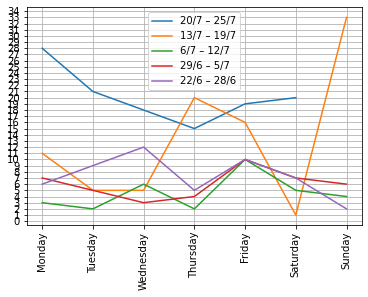

,Date_of_report,Week,Daily_delta,Total_reported
47085,2020-07-19,29,33,2824
47452,2020-07-20,30,28,2852
47819,2020-07-21,30,21,2873
48186,2020-07-22,30,18,2891
48553,2020-07-23,30,15,2906
48920,2020-07-24,30,19,2925
49287,2020-07-25,30,20,2945


In [9]:
plot_daily_delta_for_last_n_weeks(cumuldf, 5)
show()

cumuldf[["Date_of_report","Week","Daily_delta","Total_reported"]].tail(7)

In [10]:
def plot_weekly_delta_for_last_n_weeks(df, n):
    """
    Plot the weekly delta for the last n weeks

    :param df: dataframe
    :type df: pandas.DataFrame
    :param n: Last n weeks
    :type n: int
    :return: Dict
    """

    weekly_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(f"Week no. {df['Week'].max() - week} does not exist.")
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            weekly_delta[f"Week {this_week_num}"] = week_delta
            continue
    return weekly_delta



### Plot week-on-week change in reported cases

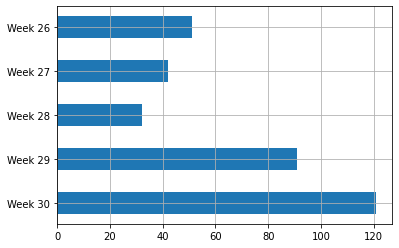

{'Week 26': 51, 'Week 27': 42, 'Week 28': 32, 'Week 29': 91, 'Week 30': 121}


In [11]:
weekly_delta = plot_weekly_delta_for_last_n_weeks(cumuldf, 5)
grid(True)
barh(list(weekly_delta.keys()), width=np.array(list(weekly_delta.values())),height=0.5)
show()
pprint(weekly_delta)

In [12]:
def weekly_percentage_incr_for_last_n_weeks(df, n):
    weekly_percent_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(f"Week no. {df['Week'].max() - week} does not exist.")
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_percent_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            last_week_delta = df[df["Week"] == (this_week_num-1)]["Daily_delta"].sum()
            weekly_percent_delta[f"Week {this_week_num}"] = ((week_delta-last_week_delta)/last_week_delta)*100

    return weekly_percent_delta

### Plot week-on-week percentage change in reported cases

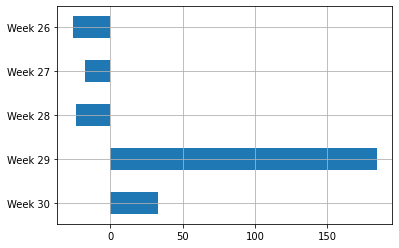

{'Week 26': -26.08695652173913,
 'Week 27': -17.647058823529413,
 'Week 28': -23.809523809523807,
 'Week 29': 184.375,
 'Week 30': 32.967032967032964}


In [13]:
grid(True)
weekly_percent_delta = weekly_percentage_incr_for_last_n_weeks(cumuldf,5)
barh(list(weekly_percent_delta.keys()), width=np.array(list(weekly_percent_delta.values())),height=0.5)
show()
pprint(weekly_percent_delta)

In [14]:
# Helper function to plot last n days cumulative reported cases

def plot_cumul_reported_last_n_days(df,n):
    plot_this = df.tail(n)
    grid(True)
    xticks(rotation="vertical")
    yticks(plot_this["Total_reported"])
    plot_date(plot_this["Date_of_report"].loc[-n:,], plot_this["Total_reported"],xdate=True )
    show()
    pprint(df[["Date_of_report", "Total_reported"]])

### Cumulative reported cases for the last 7 days

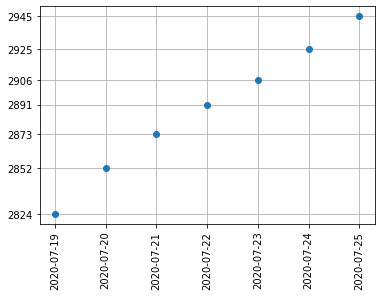

      Date_of_report  Total_reported
109       2020-03-13              20
476       2020-03-14              31
843       2020-03-15              31
1210      2020-03-16              39
1577      2020-03-17              56
...              ...             ...
47819     2020-07-21            2873
48186     2020-07-22            2891
48553     2020-07-23            2906
48920     2020-07-24            2925
49287     2020-07-25            2945

[135 rows x 2 columns]


In [17]:
plot_cumul_reported_last_n_days(cumuldf, 7)

### Cumulative reported cases for the last 14 days

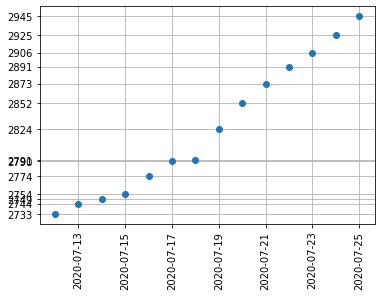

      Date_of_report  Total_reported
109       2020-03-13              20
476       2020-03-14              31
843       2020-03-15              31
1210      2020-03-16              39
1577      2020-03-17              56
...              ...             ...
47819     2020-07-21            2873
48186     2020-07-22            2891
48553     2020-07-23            2906
48920     2020-07-24            2925
49287     2020-07-25            2945

[135 rows x 2 columns]


In [15]:
plot_cumul_reported_last_n_days(cumuldf, 14)

### Cumulative reported cases for the last 30 days

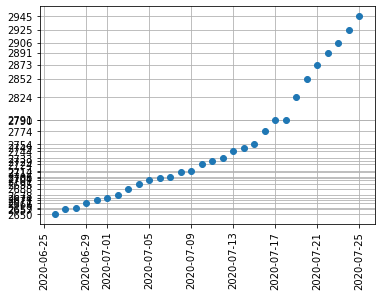

      Date_of_report  Total_reported
109       2020-03-13              20
476       2020-03-14              31
843       2020-03-15              31
1210      2020-03-16              39
1577      2020-03-17              56
...              ...             ...
47819     2020-07-21            2873
48186     2020-07-22            2891
48553     2020-07-23            2906
48920     2020-07-24            2925
49287     2020-07-25            2945

[135 rows x 2 columns]


In [16]:
plot_cumul_reported_last_n_days(cumuldf, 30)